In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
dowjones = pd.read_csv('DowJones Daily Returns.csv')
dowjones.head(10)

,PERMNO,date,SICCD,TICKER,COMNAM,HSICIG,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,NUMTRD,RETX,sprtrn,enterdate,positive,negative,total,market_cap
0,10104,2023-01-03,7372.0,ORCL,ORACLE CORP,NaN,82.260,83.8400,83.72,8997534.0,0.024223,2696253.0,NaN,0.024223,-0.004001,NaN,0.0,0.0,0.0,2.257303e+08
1,10104,2023-01-04,7372.0,ORCL,ORACLE CORP,NaN,83.640,85.1700,84.48,7836238.0,0.009078,2696253.0,NaN,0.009078,0.007539,NaN,0.0,0.0,0.0,2.277795e+08
2,10104,2023-01-05,7372.0,ORCL,ORACLE CORP,NaN,83.220,85.4000,84.31,7643784.0,-0.002012,2696253.0,NaN,-0.002012,-0.011646,NaN,0.0,0.0,0.0,2.273211e+08
3,10104,2023-01-06,7372.0,ORCL,ORACLE CORP,NaN,83.820,86.3400,85.66,8641597.0,0.016012,2696253.0,NaN,0.016012,0.022841,NaN,0.0,0.0,0.0,2.309610e+08
4,10104,2023-01-09,7372.0,ORCL,ORACLE CORP,NaN,86.160,87.5900,86.42,7519836.0,0.012608,2696253.0,NaN,0.008872,-0.000768,NaN,0.0,0.0,0.0,2.330102e+08
5,10104,2023-01-10,7372.0,ORCL,ORACLE CORP,NaN,85.570,86.6100,86.50,5703270.0,0.000926,2696253.0,NaN,0.000926,0.006978,NaN,0.0,0.0,0.0,2.332259e+08
6,10104,2023-01-11,7372.0,ORCL,ORACLE CORP,NaN,87.090,88.6600,88.60,8359667.0,0.024277,2696253.0,NaN,0.024277,0.012849,NaN,0.0,0.0,0.0,2.388880e+08
7,10104,2023-01-12,7372.0,ORCL,ORACLE CORP,NaN,88.170,89.1950,88.78,6071099.0,0.002032,2696253.0,NaN,0.002032,0.003416,2023-01-12,1.0,0.0,1.0,2.393733e+08
8,10104,2023-01-13,7372.0,ORCL,ORACLE CORP,NaN,87.660,89.4662,89.20,5090938.0,0.004731,2696253.0,NaN,0.004731,0.003997,NaN,0.0,0.0,0.0,2.405058e+08
9,10104,2023-01-17,7372.0,ORCL,ORACLE CORP,NaN,88.425,89.4400,88.60,6550412.0,-0.006726,2696253.0,NaN,-0.006726,-0.002030,2023-01-17,0.0,0.0,1.0,2.388880e+08


             PERMNO        SICCD          BIDLO          ASKHI            PRC  \
count   7750.000000  7750.000000    7750.000000    7750.000000    7750.000000   
mean   49782.967742  5364.320000   16540.440080   16803.985020   16669.838410   
std    33326.082617  2218.008679   89487.222474   90897.978696   90177.492407   
min    10104.000000  2086.000000      24.960000      25.650000      25.170000   
25%    14541.000000  2911.000000     118.152500     121.057500     119.487500   
50%    50876.000000  5541.000000     167.524990     170.174995     169.039990   
75%    86580.000000  7372.000000     346.876190     353.200590     349.824993   
max    93436.000000  9999.000000  559100.000000  566570.000000  563072.750000   

                VOL          RET        SHROUT         RETX       sprtrn  ...  \
count  7.750000e+03  7750.000000  7.750000e+03  7750.000000  7750.000000  ...   
mean   1.977457e+07     0.001143  3.294846e+06     0.001072     0.000902  ...   
std    2.959537e+07     0.0

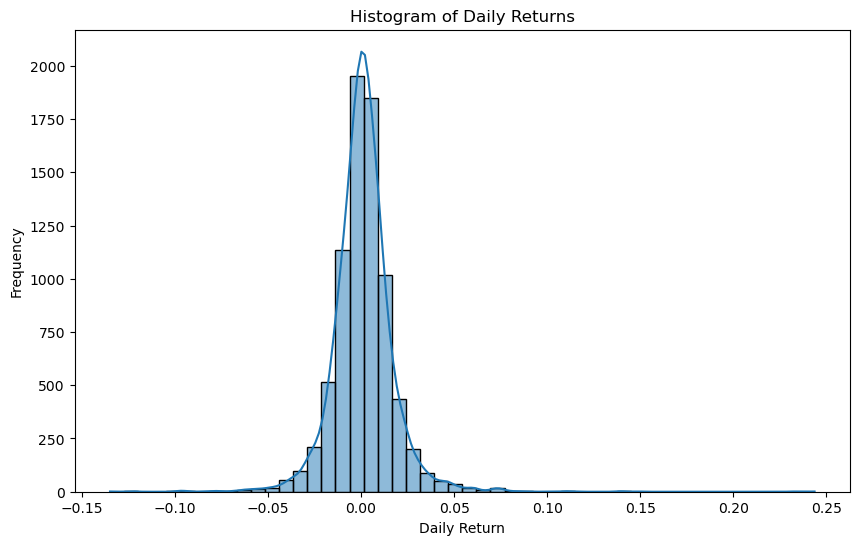

In [3]:
# Change date format
dowjones['date'] = pd.to_datetime(dowjones['date'], format='%Y-%m-%d')

# Remove the columns HSICIG and enterdate
dowjones.drop(columns=['HSICIG', 'enterdate', 'NUMTRD'], inplace=True)

# Adding lagged columns
dowjones['tomorrow_return'] = dowjones.groupby('TICKER')['RET'].shift(-1)
dowjones['yesterday_return'] = dowjones.groupby('TICKER')['RET'].shift(1)
dowjones['yesterday_volume'] = dowjones.groupby('TICKER')['VOL'].shift(1)

# Add columns for moving averages
dowjones['10_day_ma'] = dowjones['PRC'].rolling(window=10).mean()
dowjones['20_day_ma'] = dowjones['PRC'].rolling(window=20).mean()
dowjones['30_day_ma'] = dowjones['PRC'].rolling(window=30).mean()

# Create "proper?" column
dowjones['proper?'] = (dowjones['10_day_ma'] > dowjones['20_day_ma']) & (dowjones['20_day_ma'] > dowjones['30_day_ma']).astype(int)

# Create price minus 
dowjones['Ask_minus_Bid'] = dowjones['ASKHI'] - dowjones['BIDLO']

# Cr
dowjones['comp_size'] = pd.qcut(dowjones['market_cap'], q=10, labels=False)

# Summary statistics
print(dowjones.describe())

# Plot histogram of returns
plt.figure(figsize=(10, 6))
sns.histplot(data=dowjones, x='RET', bins=50, kde=True)
plt.title('Histogram of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


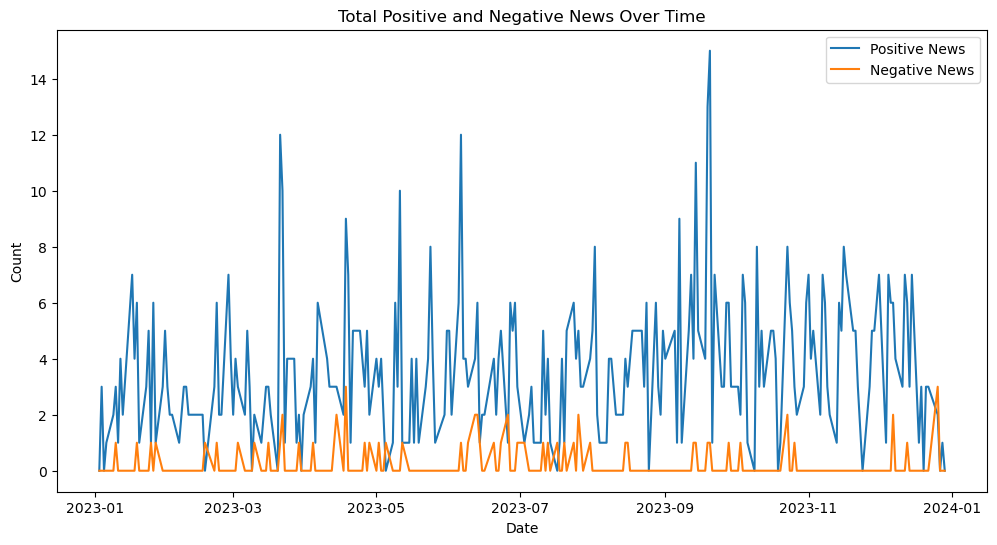

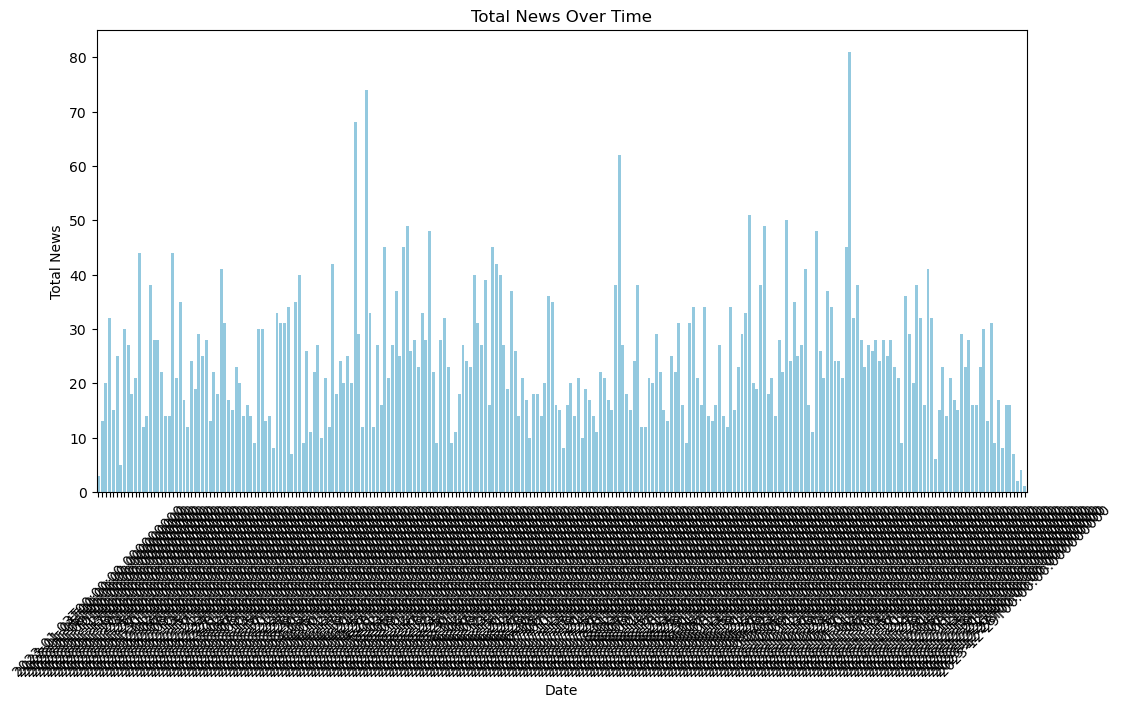

In [4]:
# Daily aggregation
daily_summary = dowjones.groupby(['date', 'sprtrn']).agg(
    sum_positive=('positive', 'sum'),
    sum_negative=('negative', 'sum'),
    sum_total=('total', 'sum')
).reset_index()

# Plot line chart of total positive and negative news over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x='date', y='sum_positive', label='Positive News')
sns.lineplot(data=daily_summary, x='date', y='sum_negative', label='Negative News')
plt.title('Total Positive and Negative News Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot bar chart of total news over time
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_summary, x='date', y='sum_total', color='skyblue')
plt.title('Total News Over Time')
plt.xlabel('Date')
plt.ylabel('Total News')
plt.xticks(rotation=45)
plt.show()

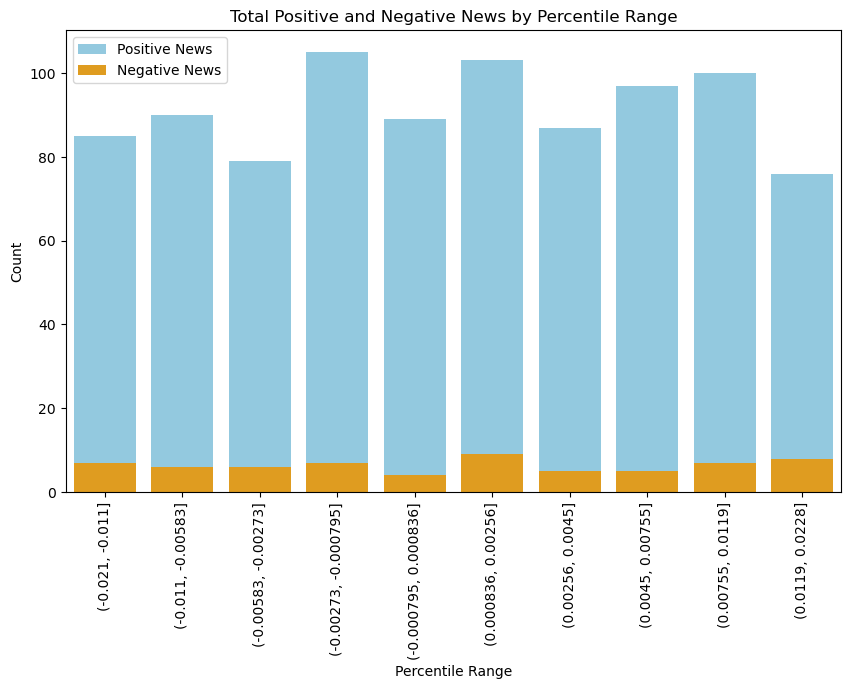

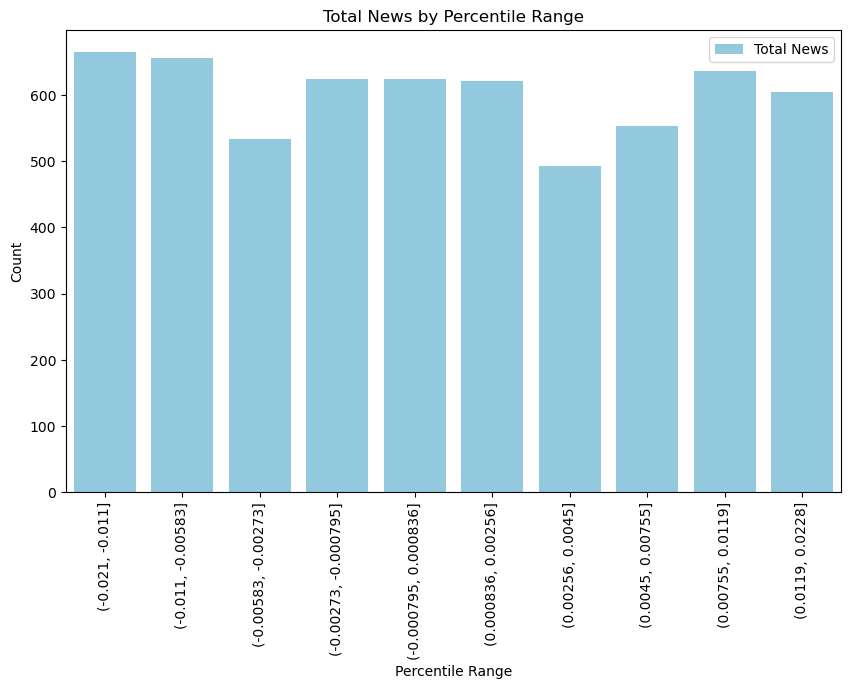

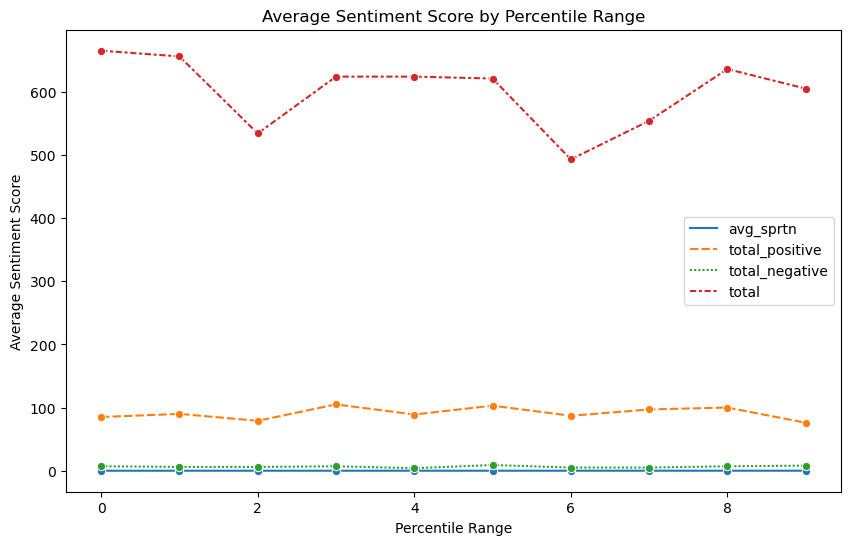

In [5]:
# Percentile summary
ranked_sprtrn = daily_summary.copy()
ranked_sprtrn['sprtrn_percentile'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10, labels=False)
ranked_sprtrn['percentile_range'] = pd.qcut(ranked_sprtrn['sprtrn'], q=10)

percentile_summary = ranked_sprtrn.groupby('percentile_range').agg(
    avg_sprtn=('sprtrn', 'mean'),
    total_positive=('sum_positive', 'sum'),
    total_negative=('sum_negative', 'sum'),
    total=('sum_total', 'sum')
).reset_index()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=percentile_summary, x='percentile_range', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot bar chart of total positive and negative news by percentile range
plt.figure(figsize=(10, 6))
sns.barplot(data=percentile_summary, x='percentile_range', y='total', color='skyblue', label='Total News')
plt.title('Total News by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()

# Plot line chart of average sentiment score by percentile range
plt.figure(figsize=(10, 6))
sns.lineplot(data=percentile_summary.drop(columns='percentile_range'), marker='o', color='green')
plt.title('Average Sentiment Score by Percentile Range')
plt.xlabel('Percentile Range')
plt.ylabel('Average Sentiment Score')
plt.show()


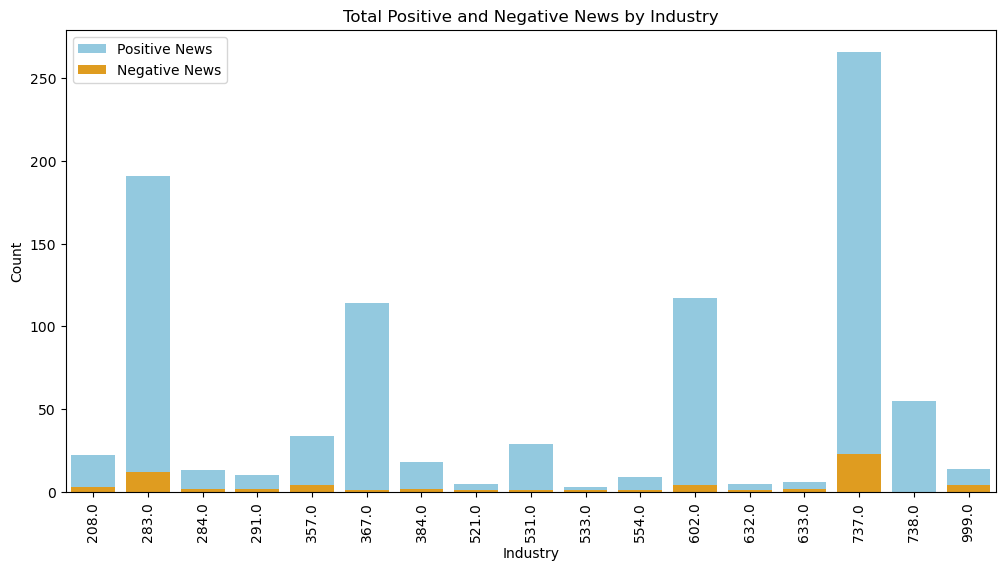

In [6]:
# Industry summary
industry_summary = dowjones.groupby(dowjones['SICCD'] // 10).agg(
    num_firms=('TICKER', 'nunique'),
    cum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

industry_summary['positive_perc'] = industry_summary['total_positive'] / industry_summary['total']
industry_summary['negative_perc'] = industry_summary['total_negative'] / industry_summary['total']

# Plot bar chart of total positive and negative news by industry
plt.figure(figsize=(12, 6))
sns.barplot(data=industry_summary, x='SICCD', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=industry_summary, x='SICCD', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Industry')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.legend()
plt.show()


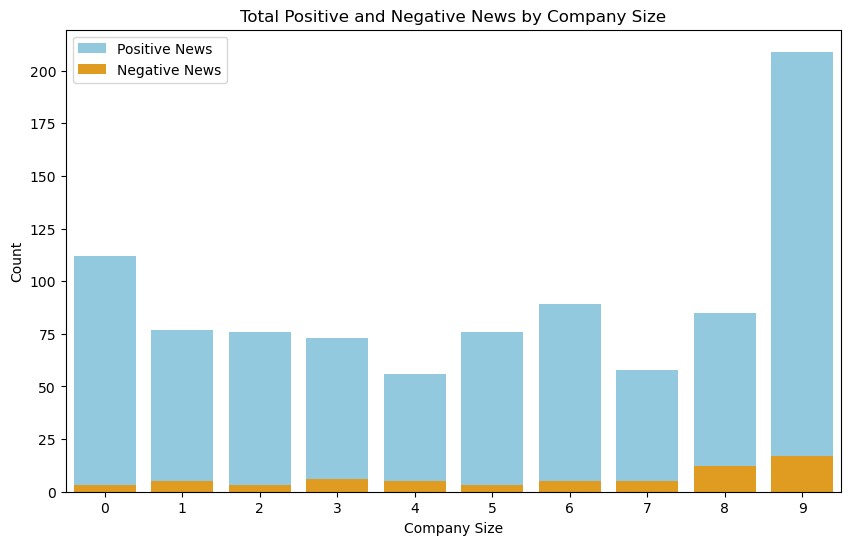

In [7]:
# Company size summary
stock_size = dowjones.copy()
stock_size['comp_size'] = pd.qcut(stock_size['market_cap'], q=10, labels=False)
company_size_summary = stock_size.groupby('comp_size').agg(
    sum_ret=('RET', 'sum'),
    total_positive=('positive', 'sum'),
    total_negative=('negative', 'sum'),
    total=('total', 'sum')
).reset_index()

company_size_summary['positive_perc'] = company_size_summary['total_positive'] / company_size_summary['total']
company_size_summary['negative_perc'] = company_size_summary['total_negative'] / company_size_summary['total']

# Plot bar chart of total positive and negative news by company size
plt.figure(figsize=(10, 6))
sns.barplot(data=company_size_summary, x='comp_size', y='total_positive', color='skyblue', label='Positive News')
sns.barplot(data=company_size_summary, x='comp_size', y='total_negative', color='orange', label='Negative News')
plt.title('Total Positive and Negative News by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.legend()
plt.show()


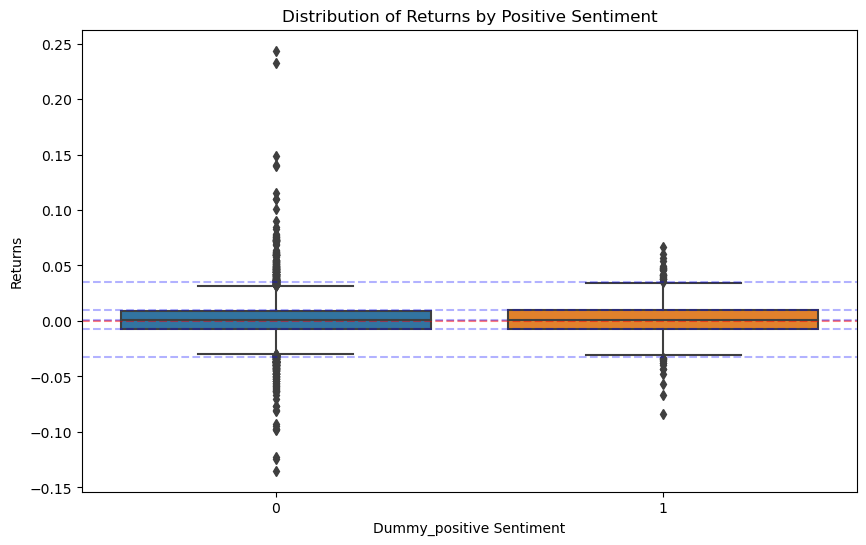

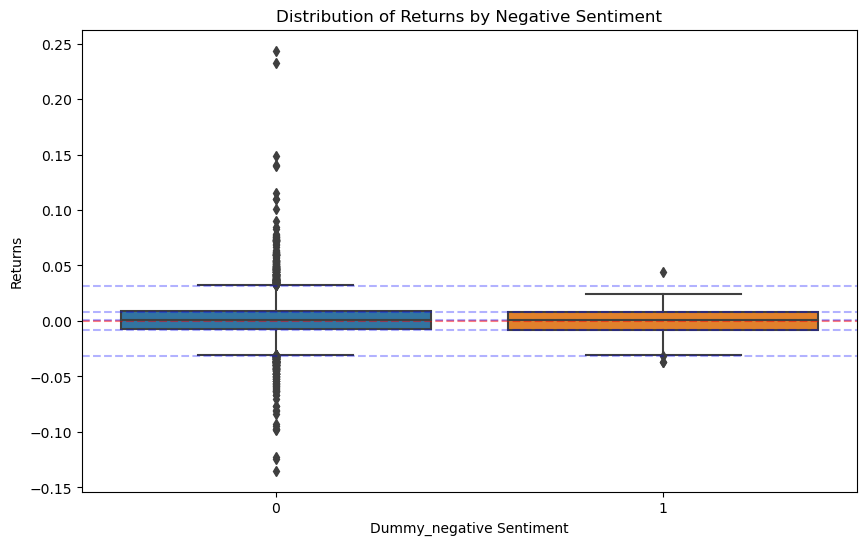

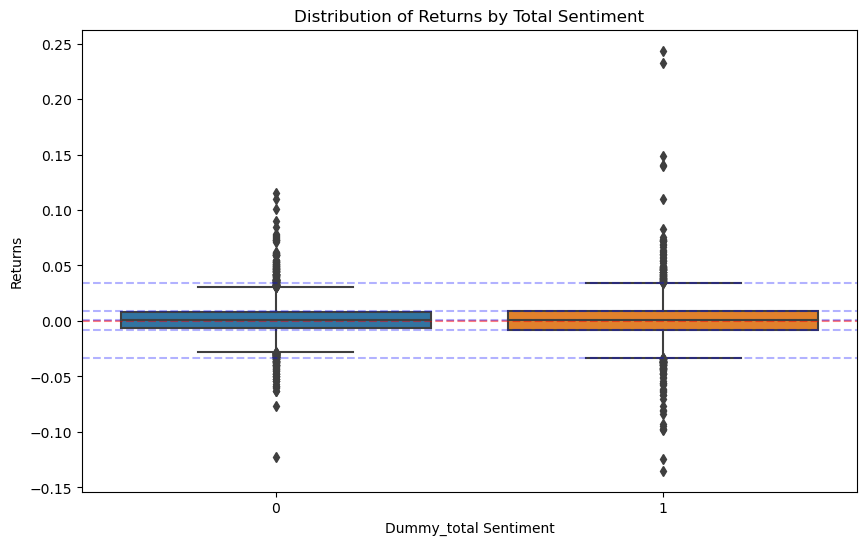

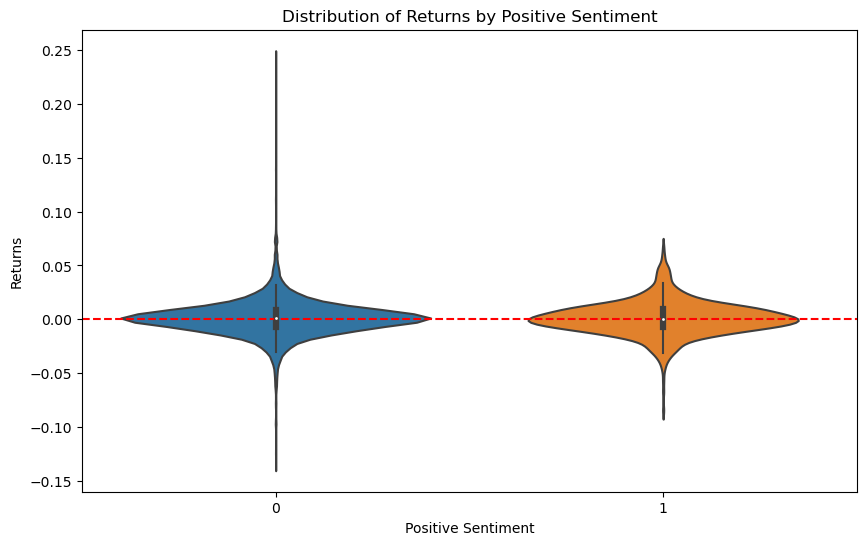

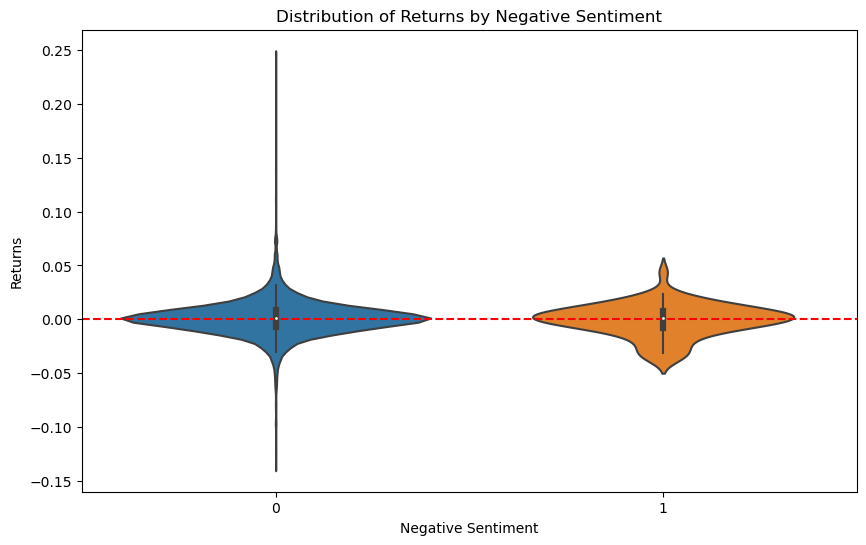

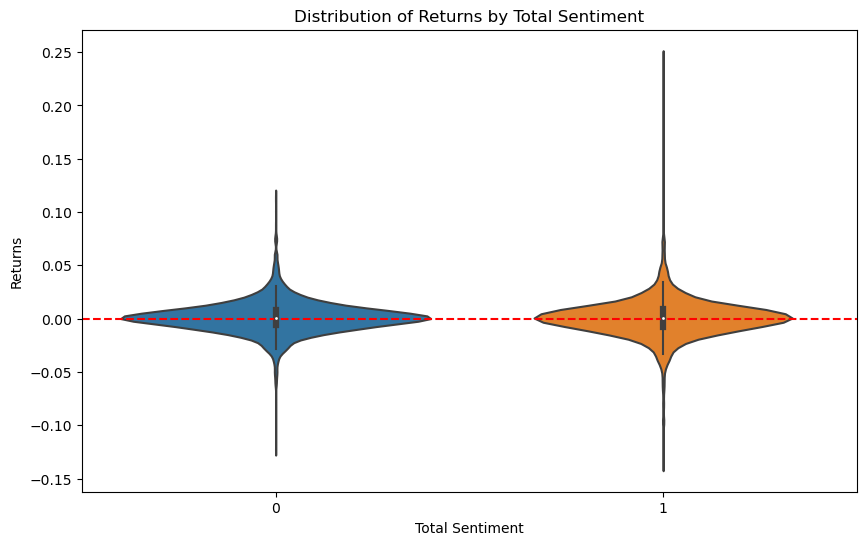

In [8]:
# Create dummy_negative column
dowjones['dummy_negative'] = (dowjones['negative'] >= 1).astype(int)

# Create dummy_positive column
dowjones['dummy_positive'] = (dowjones['positive'] >= 1).astype(int)

# Create dummy_total column
dowjones['dummy_total'] = (dowjones['total'] >= 1).astype(int)


# Function to plot with additional lines
def plot_with_lines(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    # Add blue dashed lines for critical points of value >= 1 category
    for i, box in enumerate(data.groupby(x_col)[y_col]):
        if box[0] == 1:
            quartiles = box[1].quantile([0.25, 0.5, 0.75])
            plt.axhline(y=quartiles[0.25], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.5], color='blue', linestyle='--', alpha=0.3)
            plt.axhline(y=quartiles[0.75], color='blue', linestyle='--', alpha=0.3)              
            iqr = quartiles[0.75] - quartiles[0.25]
            upper_limit = 1.5 * iqr + quartiles[0.75]
            lower_limit = quartiles[0.25] - 1.5 * iqr
            # Add additional blue dashed lines
            plt.axhline(y=upper_limit, color='blue', linestyle='--', alpha=0.3)  # Upper limit
            plt.axhline(y=lower_limit, color='blue', linestyle='--', alpha=0.3)  # Lower limit
    plt.title(title)
    plt.xlabel(x_col.capitalize() + ' Sentiment')
    plt.ylabel('Returns')
    plt.show()


# Box plot for dummy_positive
plot_with_lines(dowjones, 'dummy_positive', 'RET', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(dowjones, 'dummy_negative', 'RET', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(dowjones, 'dummy_total', 'RET', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='RET', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='RET', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='RET', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()


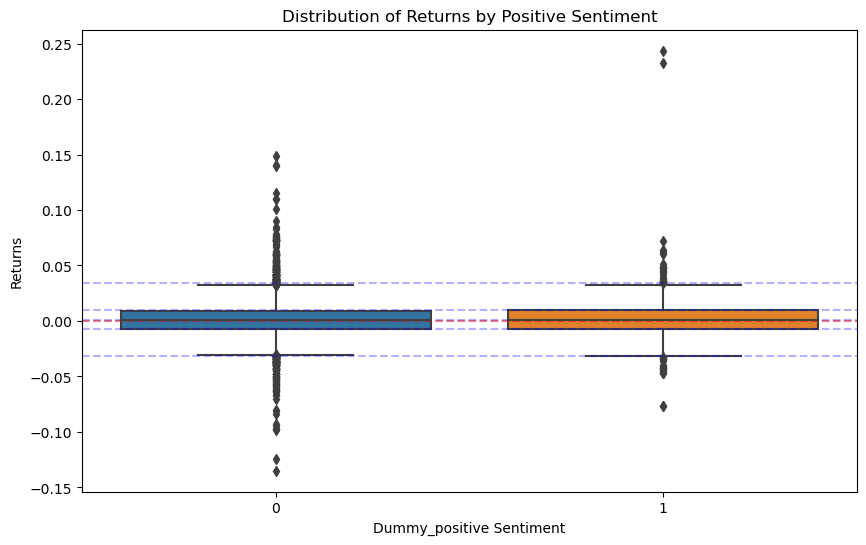

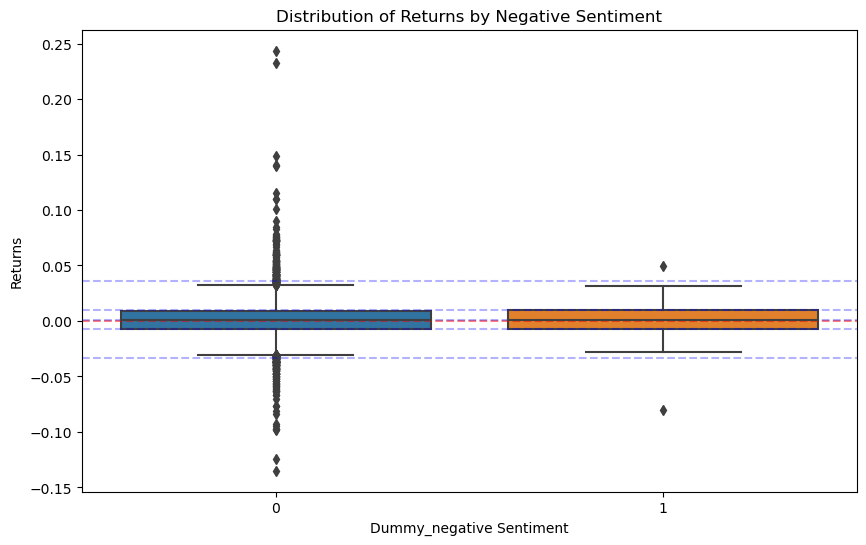

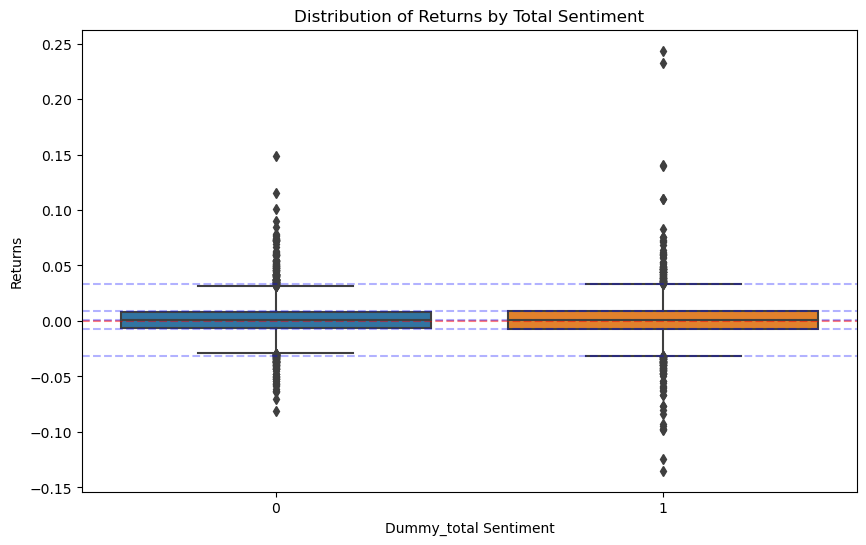

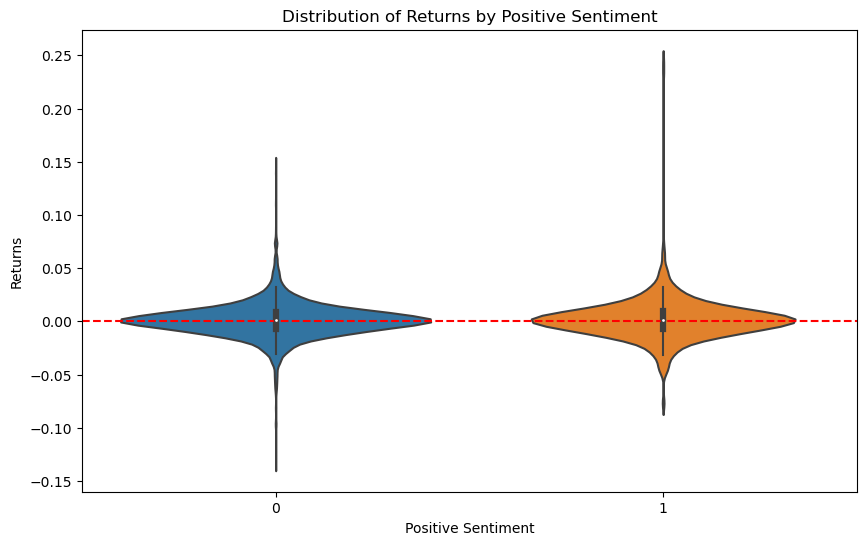

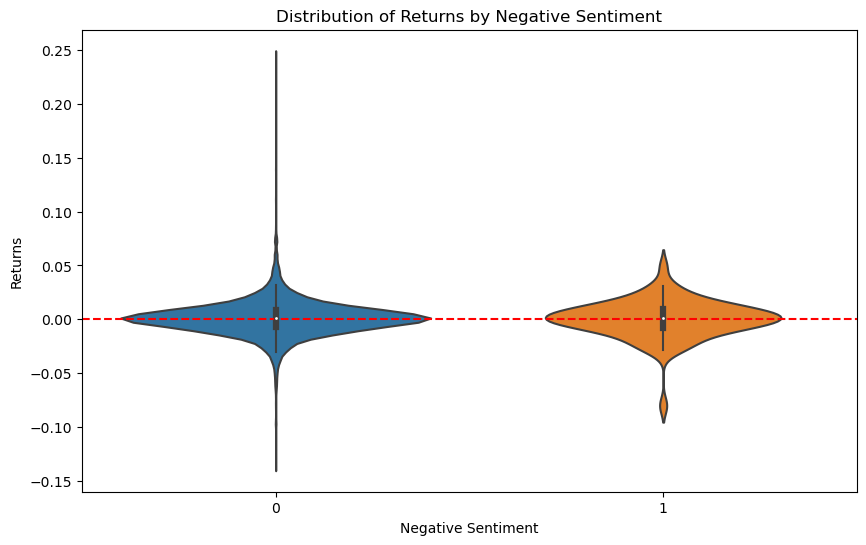

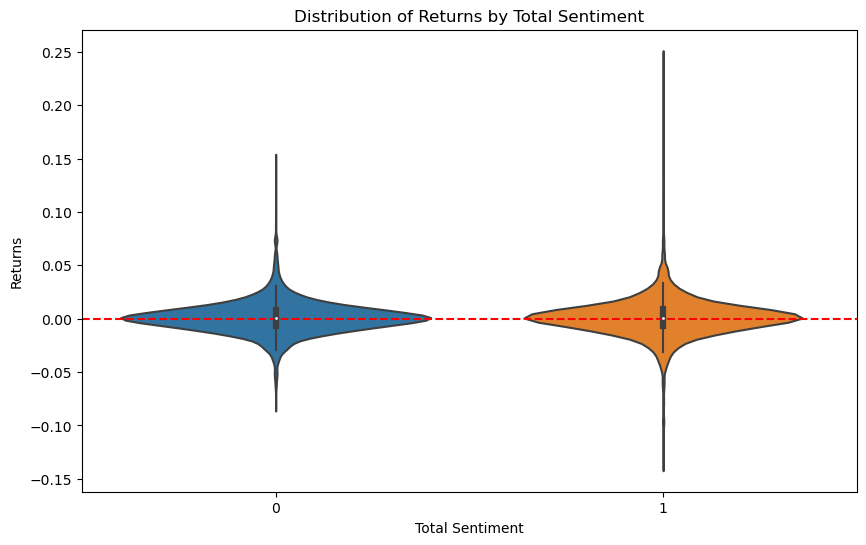

In [9]:
# Box plot for dummy_positive
plot_with_lines(dowjones, 'dummy_positive', 'tomorrow_return', 'Distribution of Returns by Positive Sentiment')

# Box plot for dummy_negative
plot_with_lines(dowjones, 'dummy_negative', 'tomorrow_return', 'Distribution of Returns by Negative Sentiment')

# Box plot for dummy_total
plot_with_lines(dowjones, 'dummy_total', 'tomorrow_return', 'Distribution of Returns by Total Sentiment')

# Violin plot for dummy_positive
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_positive', y='tomorrow_return', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Positive Sentiment')
plt.xlabel('Positive Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_negative
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_negative', y='tomorrow_return', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Negative Sentiment')
plt.xlabel('Negative Sentiment')
plt.ylabel('Returns')
plt.show()

# Violin plot for dummy_total
plt.figure(figsize=(10, 6))
sns.violinplot(x='dummy_total', y='tomorrow_return', data=dowjones)
plt.axhline(y=0, color='red', linestyle='--') 
plt.title('Distribution of Returns by Total Sentiment')
plt.xlabel('Total Sentiment')
plt.ylabel('Returns')
plt.show()

In [10]:
from scipy.stats import ttest_ind, mannwhitneyu

# Define a function to remove outliers using Z-score
def remove_outliers(df, column, threshold=3):
    z_scores = (df[column] - df[column].mean()) / df[column].std()
    df_filtered = df[(z_scores.abs() < threshold)]
    return df_filtered

# Remove outliers from the dowjones DataFrame
dowjones = remove_outliers(dowjones, 'Ask_minus_Bid')
dowjones = remove_outliers(dowjones, 'VOL')
dowjones.to_csv('daily_dowjones_regression.csv', index=False)

# Calculate mean and standard deviation (volatility) for each combination of dummy variables
mean_negative = dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'].mean()
std_negative = dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'].std()

mean_positive = dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'].mean()
std_positive = dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'].std()

mean_total = dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'].mean()
std_total = dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'].std()

# Calculate mean and standard deviation (volatility) when the dummy variables are equal to zero
mean_negative_zero = dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'].mean()
std_negative_zero = dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'].std()

mean_positive_zero = dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'].mean()
std_positive_zero = dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'].std()

mean_total_zero = dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'].mean()
std_total_zero = dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'].std()

# t-test for mean difference
t_statistic_mean_negative, p_value_mean_negative = ttest_ind(dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                             dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'])

t_statistic_mean_positive, p_value_mean_positive = ttest_ind(dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                             dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'])

t_statistic_mean_total, p_value_mean_total = ttest_ind(dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'],
                                                       dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'])

# Mann-Whitney U test for difference in volatility
u_statistic_vol_negative, p_value_vol_negative = mannwhitneyu(dowjones[dowjones['dummy_negative'] == 1]['Ask_minus_Bid'],
                                                              dowjones[dowjones['dummy_negative'] == 0]['Ask_minus_Bid'])

u_statistic_vol_positive, p_value_vol_positive = mannwhitneyu(dowjones[dowjones['dummy_positive'] == 1]['Ask_minus_Bid'],
                                                              dowjones[dowjones['dummy_positive'] == 0]['Ask_minus_Bid'])

u_statistic_vol_total, p_value_vol_total = mannwhitneyu(dowjones[dowjones['dummy_total'] == 1]['Ask_minus_Bid'],
                                                        dowjones[dowjones['dummy_total'] == 0]['Ask_minus_Bid'])

# Create a DataFrame to display the results
data = {
    'Dummy': ['Negative', 'Positive', 'Total'],
    'Mean_with_Dummy': [mean_negative, mean_positive, mean_total],
    'Mean_without_Dummy': [mean_negative_zero, mean_positive_zero, mean_total_zero],
    'Volatility_with_Dummy': [std_negative, std_positive, std_total],
    'Volatility_without_Dummy': [std_negative_zero, std_positive_zero, std_total_zero],
    'Mean_Difference': [mean_negative - mean_negative_zero,
                        mean_positive - mean_positive_zero,
                        mean_total - mean_total_zero],
    'Volatility_Difference': [std_negative - std_negative_zero,
                              std_positive - std_positive_zero,
                              std_total - std_total_zero],
    'Mean_P_value': [p_value_mean_negative, p_value_mean_positive, p_value_mean_total],
    'Volatility_P_value': [p_value_vol_negative, p_value_vol_positive, p_value_vol_total]
}
df_results = pd.DataFrame(data)

# Display the results
print(df_results)

      Dummy  Mean_with_Dummy  Mean_without_Dummy  Volatility_with_Dummy  \
0  Negative         3.657731           19.135270               3.042094   
1  Positive         4.598033           20.660279               5.793348   
2     Total         5.515714           27.722144              59.844699   

   Volatility_without_Dummy  Mean_Difference  Volatility_Difference  \
0                247.222256       -15.477538            -244.180162   
1                259.883642       -16.062246            -254.090294   
2                311.884020       -22.206430            -252.039321   

   Mean_P_value  Volatility_P_value  
0      0.627756        6.682273e-01  
1      0.090386        2.986911e-02  
2      0.000167        9.700405e-13  


In [11]:
# Specify the columns for which to calculate z-scores
columns_to_standardize = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'RETX', 'sprtrn', 'market_cap', 'yesterday_return', '10_day_ma', '20_day_ma', 
                          '30_day_ma', 'Ask_minus_Bid', 'yesterday_volume']

# Group by ticker and standardize each group for specified columns
dowjones_grouped = dowjones.groupby('TICKER')[columns_to_standardize]

# Define a function to standardize values within each group
def standardize_group(group):
    group_std = (group - group.mean()) / group.std()
    return group_std

# Apply the standardization function to each group
dowjones_standardized = dowjones_grouped.transform(standardize_group)

# Replace original values with standardized values in the original DataFrame
dowjones[columns_to_standardize] = dowjones_standardized

# Check the modified DataFrame
print(dowjones.head())

   PERMNO       date   SICCD TICKER       COMNAM     BIDLO     ASKHI  \
0   10104 2023-01-03  7372.0   ORCL  ORACLE CORP -1.734754 -1.724572   
1   10104 2023-01-04  7372.0   ORCL  ORACLE CORP -1.618904 -1.616386   
2   10104 2023-01-05  7372.0   ORCL  ORACLE CORP -1.654163 -1.597677   
3   10104 2023-01-06  7372.0   ORCL  ORACLE CORP -1.603793 -1.521216   
4   10104 2023-01-09  7372.0   ORCL  ORACLE CORP -1.407352 -1.419537   

        PRC       VOL       RET  ...  yesterday_volume  10_day_ma  20_day_ma  \
0 -1.686519 -0.022160  1.206826  ...               NaN        NaN        NaN   
1 -1.623505 -0.184599  0.410695  ...         -0.023385        NaN        NaN   
2 -1.637600 -0.211519 -0.172276  ...         -0.185530        NaN        NaN   
3 -1.525667 -0.071948  0.775196  ...         -0.212402        NaN        NaN   
4 -1.462653 -0.228857  0.596257  ...         -0.073083        NaN        NaN   

   30_day_ma  proper?  Ask_minus_Bid  comp_size  dummy_negative  \
0        NaN    Fal

Kurtosis:
BIDLO               -0.390506
ASKHI               -0.406446
PRC                 -0.385988
VOL                 15.242459
RET                  4.867922
SHROUT               0.025842
RETX                 4.834347
sprtrn              -0.199791
market_cap          -0.575049
yesterday_return     6.184976
10_day_ma           15.676313
20_day_ma            8.167600
30_day_ma            5.092499
Ask_minus_Bid       19.083682
yesterday_volume    18.117800
dtype: float64

Skewness:
BIDLO               0.128949
ASKHI               0.135230
PRC                 0.140623
VOL                 2.976363
RET                -0.091405
SHROUT              0.064805
RETX               -0.090751
sprtrn             -0.013133
market_cap         -0.050105
yesterday_return    0.047350
10_day_ma           1.412392
20_day_ma           0.875718
30_day_ma           0.637281
Ask_minus_Bid       2.797325
yesterday_volume    3.310039
dtype: float64


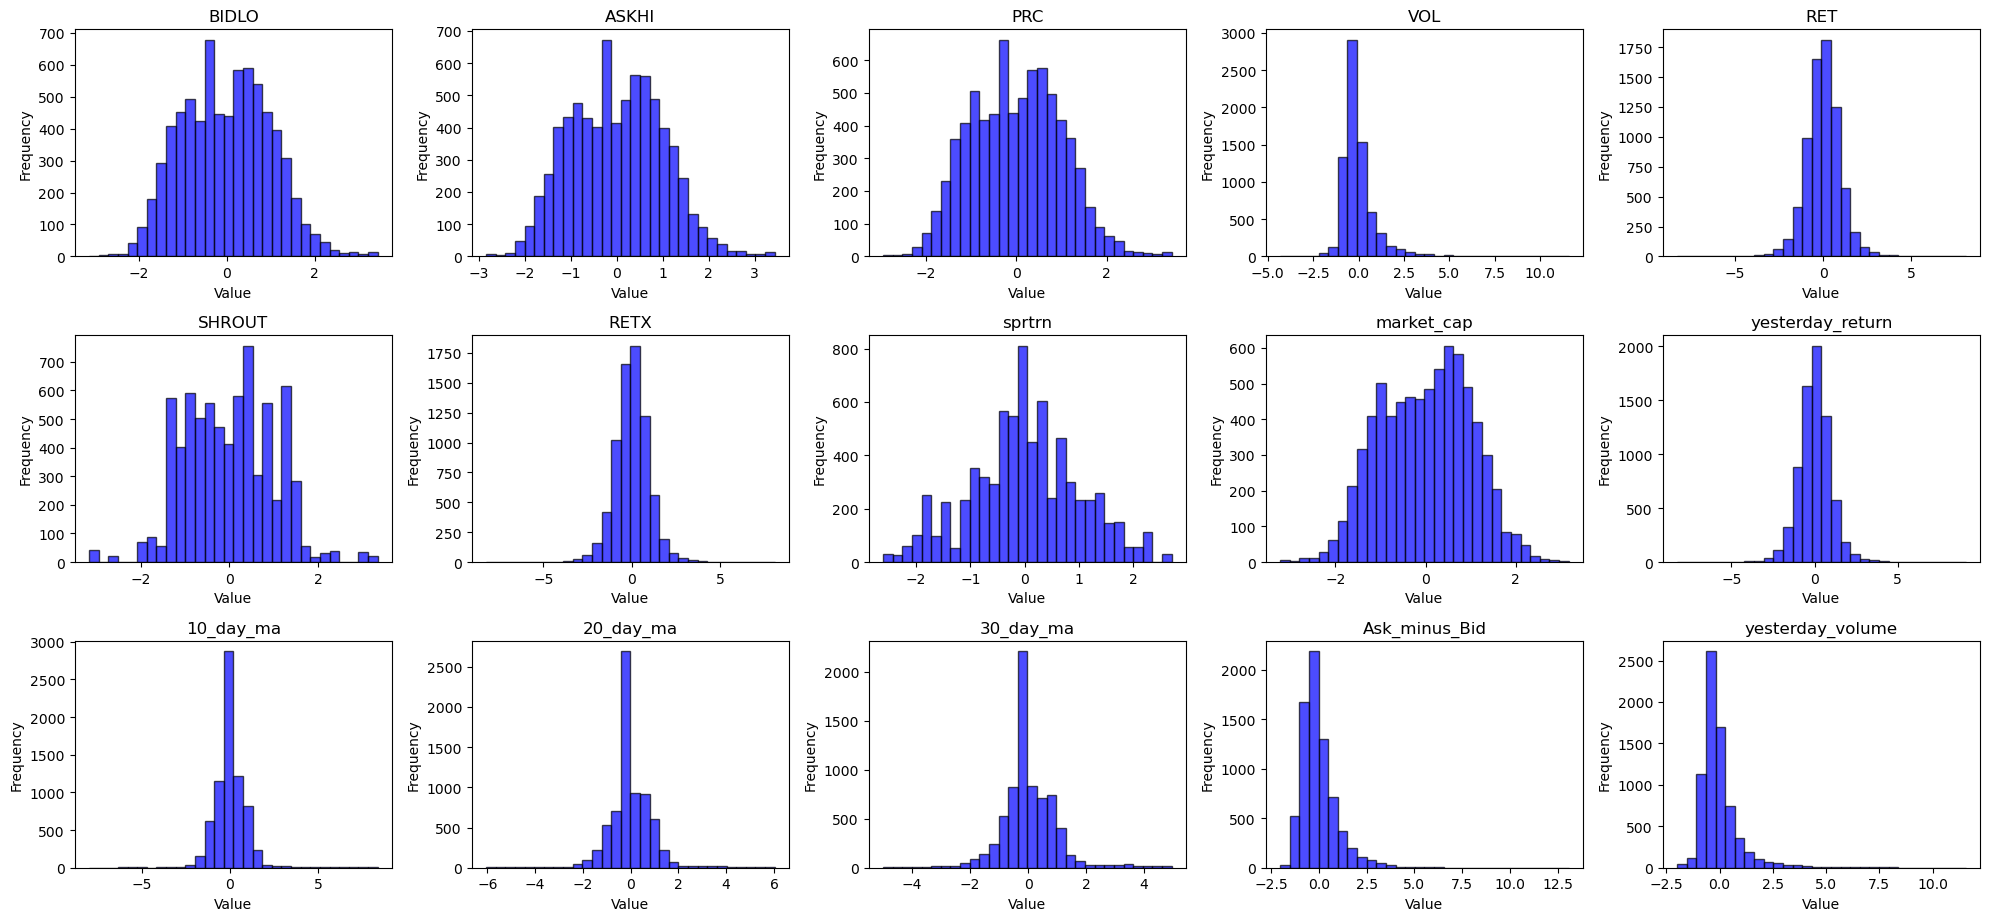

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate kurtosis and skewness for each numeric variable
numeric_columns = ['BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'SHROUT', 'RETX', 'sprtrn', 'market_cap', 'yesterday_return', 
                   '10_day_ma', '20_day_ma', '30_day_ma', 'Ask_minus_Bid', 'yesterday_volume']
kurtosis_values = dowjones[numeric_columns].kurtosis()
skewness_values = dowjones[numeric_columns].skew()

# Print kurtosis and skewness values for each numeric variable
print("Kurtosis:")
print(kurtosis_values)
print("\nSkewness:")
print(skewness_values)

# Plot histograms for each numeric variable
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 5, i)
    plt.hist(dowjones[col], bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
dowjones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7301 entries, 0 to 7749
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PERMNO            7301 non-null   int64         
 1   date              7301 non-null   datetime64[ns]
 2   SICCD             7301 non-null   float64       
 3   TICKER            7301 non-null   object        
 4   COMNAM            7301 non-null   object        
 5   BIDLO             7301 non-null   float64       
 6   ASKHI             7301 non-null   float64       
 7   PRC               7301 non-null   float64       
 8   VOL               7301 non-null   float64       
 9   RET               7301 non-null   float64       
 10  SHROUT            7301 non-null   float64       
 11  RETX              7301 non-null   float64       
 12  sprtrn            7301 non-null   float64       
 13  positive          7301 non-null   float64       
 14  negative          7301 n

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

# Convert specified columns to categorical
dowjones['SICCD'] = dowjones['SICCD'].astype('category')
dowjones['comp_size'] = dowjones['comp_size'].astype('category')
dowjones['proper?'] = dowjones['proper?'].astype('category')
dowjones['dummy_negative'] = dowjones['dummy_negative'].astype('category')
dowjones['dummy_positive'] = dowjones['dummy_positive'].astype('category')
dowjones['dummy_total'] = dowjones['dummy_total'].astype('category')

dowjones.to_csv('standardized_daily_dowjones_regression.csv', index=False)
dowjones_clean = dowjones.dropna()

# Select features and target variable
features = dowjones_clean.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date'])
target = dowjones_clean['tomorrow_return']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
    ])

# Define LassoCV model
lasso_cv = LassoCV(cv=5, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lasso', lasso_cv)])

# Fit the model
pipeline.fit(X_train, y_train)

# Print the best alpha
print("Best alpha:", pipeline.named_steps['lasso'].alpha_)

# Print the R^2 score
print("R^2 score:", pipeline.score(X_test, y_test))

# Access the model coefficients
model_coefs = pipeline.named_steps['lasso'].coef_
print("Model coefficients:", model_coefs)

C:\Users\joel3\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002612518583988699, tolerance: 0.00011888540867845994
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joel3\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026580403859721713, tolerance: 0.00011888540867845994
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joel3\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026575355706404125, tolerance: 0.00011888540867845994
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\joel3\anaconda\Lib\site-packages\sklearn\linear_model\_coor

Best alpha: 0.0001390962709011255
R^2 score: 0.018586317958035115
Model coefficients: [ 3.14279142e-04  2.20918545e-04 -1.01659763e-03 -0.00000000e+00
 -2.58268476e-04  5.87870489e-04  0.00000000e+00 -6.61323482e-04
  6.65496766e-05  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -3.47796255e-04 -3.47206519e-04  1.55976709e-04
 -6.21834574e-05 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  3.45383630e-04 -0.00000000e+00  1.86309771e-04
  4.22409419e-05]


In [15]:
dowjones1 = dowjones.copy()
dowjones1.to_csv('standardized_dowjones_regression.csv', index=False)

C:\Users\joel3\AppData\Local\Temp\ipykernel_26204\70535258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dowjones['pred_lasso'] = pipeline.predict(dowjones.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date']))


    PERMNO       date   SICCD TICKER       COMNAM     BIDLO     ASKHI  \
29   10104 2023-02-14  7372.0   ORCL  ORACLE CORP -1.277230 -1.271494   
30   10104 2023-02-15  7372.0   ORCL  ORACLE CORP -1.250367 -1.287763   
31   10104 2023-02-16  7372.0   ORCL  ORACLE CORP -1.335777 -1.364225   
32   10104 2023-02-17  7372.0   ORCL  ORACLE CORP -1.377970 -1.432552   
33   10104 2023-02-21  7372.0   ORCL  ORACLE CORP -1.408191 -1.472410   

         PRC       VOL       RET  ...  10_day_ma  20_day_ma  30_day_ma  \
29 -1.241274 -0.233761 -0.260484  ...  -1.361326  -1.432389  -1.543900   
30 -1.303459 -0.674966 -0.509022  ...  -1.375925  -1.425246  -1.530019   
31 -1.354865 -0.449486 -0.435428  ...  -1.390098  -1.417445  -1.520284   
32 -1.391347 -0.385708 -0.330188  ...  -1.410076  -1.417313  -1.511361   
33 -1.480894 -0.544911 -0.716978  ...  -1.429969  -1.429453  -1.509739   

    proper?  Ask_minus_Bid  comp_size  dummy_negative  dummy_positive  \
29     True      -0.363143          1      

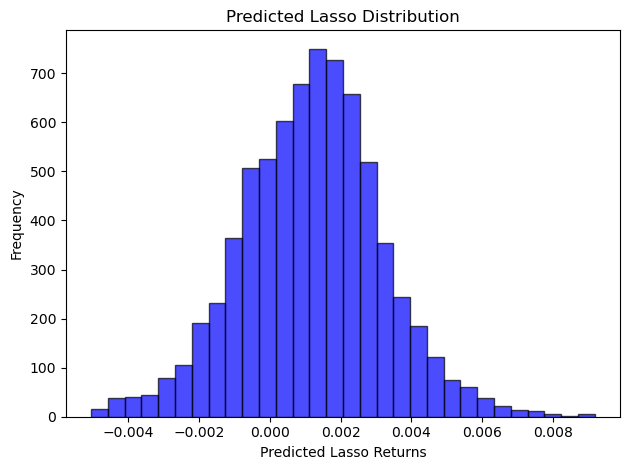

In [16]:
dowjones = dowjones.dropna()

# Add a new column 'pred_lasso' to the dowjones dataframe with predictions
dowjones['pred_lasso'] = pipeline.predict(dowjones.drop(columns=['tomorrow_return', 'TICKER', 'COMNAM', 'date']))

# Display the first few rows of the dataframe to verify the new column
print(dowjones.head())

plt.hist(dowjones['pred_lasso'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Predicted Lasso Distribution')
plt.xlabel('Predicted Lasso Returns')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=12)

# Create pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('random_forest', rf_model)])

# Define parameter grid
param_grid = {
    'random_forest__n_estimators': [50, 100],
    'random_forest__max_depth': [None, 10],
    'random_forest__min_samples_split': [2, 5],
    'random_forest__min_samples_leaf': [1, 2]
}

# Perform grid search with reduced parameters and folds
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Print the best R^2 score
print("Best R^2 score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print("Test set R^2 score of the best model:", test_score)
